## Project: Predicting CS Staffing Needs

### Aim: to predict the number of customer service complaint tickets for the following month based on historical and current data.

#### Framing the problem:

Before proceeding to Exploratory Data Analysis (EDA), it is important to understand how the company expects to use and benefit from this model. This will help me determine how to frame the problem, what algorithms to select and how to evaluate the performance of each one.

I can categorize my Machine Learning system as:
 - Supervised learning task: I am given some labeled data that I can split into training and testing sets (in plain English - I already have comprehensive data on past complaint tickets and I can observe how many tickets were received in a given space of time (every month, week, day, hour or even minute)).
 - Regression task: my algorithms is expected to predict the number of complaint tickets received in a given period of time.
 - Plain batch learning: since there is no continuous flow of data coming into my system, there is no particular need to adjust to changing data rapidly. In addition, the data is small enough to fit in memory, so plain batch learning should suffice.

### Understanding the data:

Before proceeding to analysis, let's understand what kind of data we have. Since I have to predict daily number of complaint tickets that will be received by our CS agents in this market for the next month, I will have to transform my raw data into the kind of data that has data points indexed or sequenced in time-based order with the 24 hour interval between observations. Hence, what I have is also known as **time-series** data. Other examples of time-series data include daily average temperatures of a given city, hourly bid price of a certain stock etc. Using time-series forecasting will enable us to establish monthly, quaterly or even annual staffing capacity planning for our Customer Support Division to answer the demand, in this case, the number of incoming complaint tickets. 

Time-series forecasting is known for its difficulty due to its inherent uncertainty. It is indeed quite difficult to tell whether a series can be categorized as stochastic, deterministic, chaotic or a combination of those.

As a general rule of thumb, to ensure reasonably accurate forecasts my time series should **ideally** meet the following characteristics:

 - Hourly, daily or weekly observation within at least a few months (minimum 1 month), but 1 year of historical data is much preferred.

 - Data should be strongly seasonal - there should be regularly spaced patterns over the course of a week or between seasons of a year.

 - Important events (e.g. new product feature launches) or holidays that occur must be noted

 - A reasonable number of missing or outlier (inlier) data

 - Historical **trend** changes

### Initializing packages and importing data

In [14]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
os.chdir("/Users/aida.aman/Desktop/Bolt")
import statsmodels.tsa.seasonal as season
import warnings
import pprint
warnings.filterwarnings("ignore")

Let's load up some data. It's important to remember that for the purposes of this project I only have access to three months of historical data.

In [15]:
tickets = pd.read_csv("/Users/aida.aman/Desktop/Bolt/tickets.csv")

### Data pre-processing:

Since I have raw data containing information on each individual ticket received between November 1, 2019 and January 30, 2020, I have to select unique incoming tickets and aggregate them to obtain a daily time series. 

The dataset contains auto-solved or duplicate tickets that did not merit a response by an agent. I shall exclude those by dropping observations where the value for  *first_response_time*  is missing because this means that the complaint was closed by an agent without a reply. Otherwise, everything seems to be in order. No further transformations to the data are required.

In [3]:
tickets = tickets.dropna(how ='all', subset=['first_response_time'])

Now, I will create a daily time series of **incoming** tickets by summing up the values for the same day.

In [4]:
tickets = tickets.rename(columns={"ticket_created_at": "ds"})
tickets['ds']=pd.to_datetime(tickets['ds'])
tickets = tickets.set_index(pd.DatetimeIndex(tickets['ds']))
tickets['is_incoming']=tickets['is_incoming'].replace('t', 1)
tickets['is_incoming']=tickets['is_incoming'].replace('f', 0)
tickets_daily = tickets['is_incoming'].resample('D').sum()
tickets_daily = tickets_daily.to_frame()
tickets_daily = tickets_daily.rename(columns={"is_incoming": "y"})

### Exploration

Any time series has 4 components:
1. **Trend** - an increase or decrease in values. It can be linear or nonlinear (e.g. logistic)
2. **Seasonality** - regular and predictable movement after a fixed period of time
3. **Cycles** - regular or periodic fluctuation in the data
4. **Noise** - whatever is left after the trend-cycle and the seasonal components have been removed

To start things off, I will plot my time series for visual inspection.

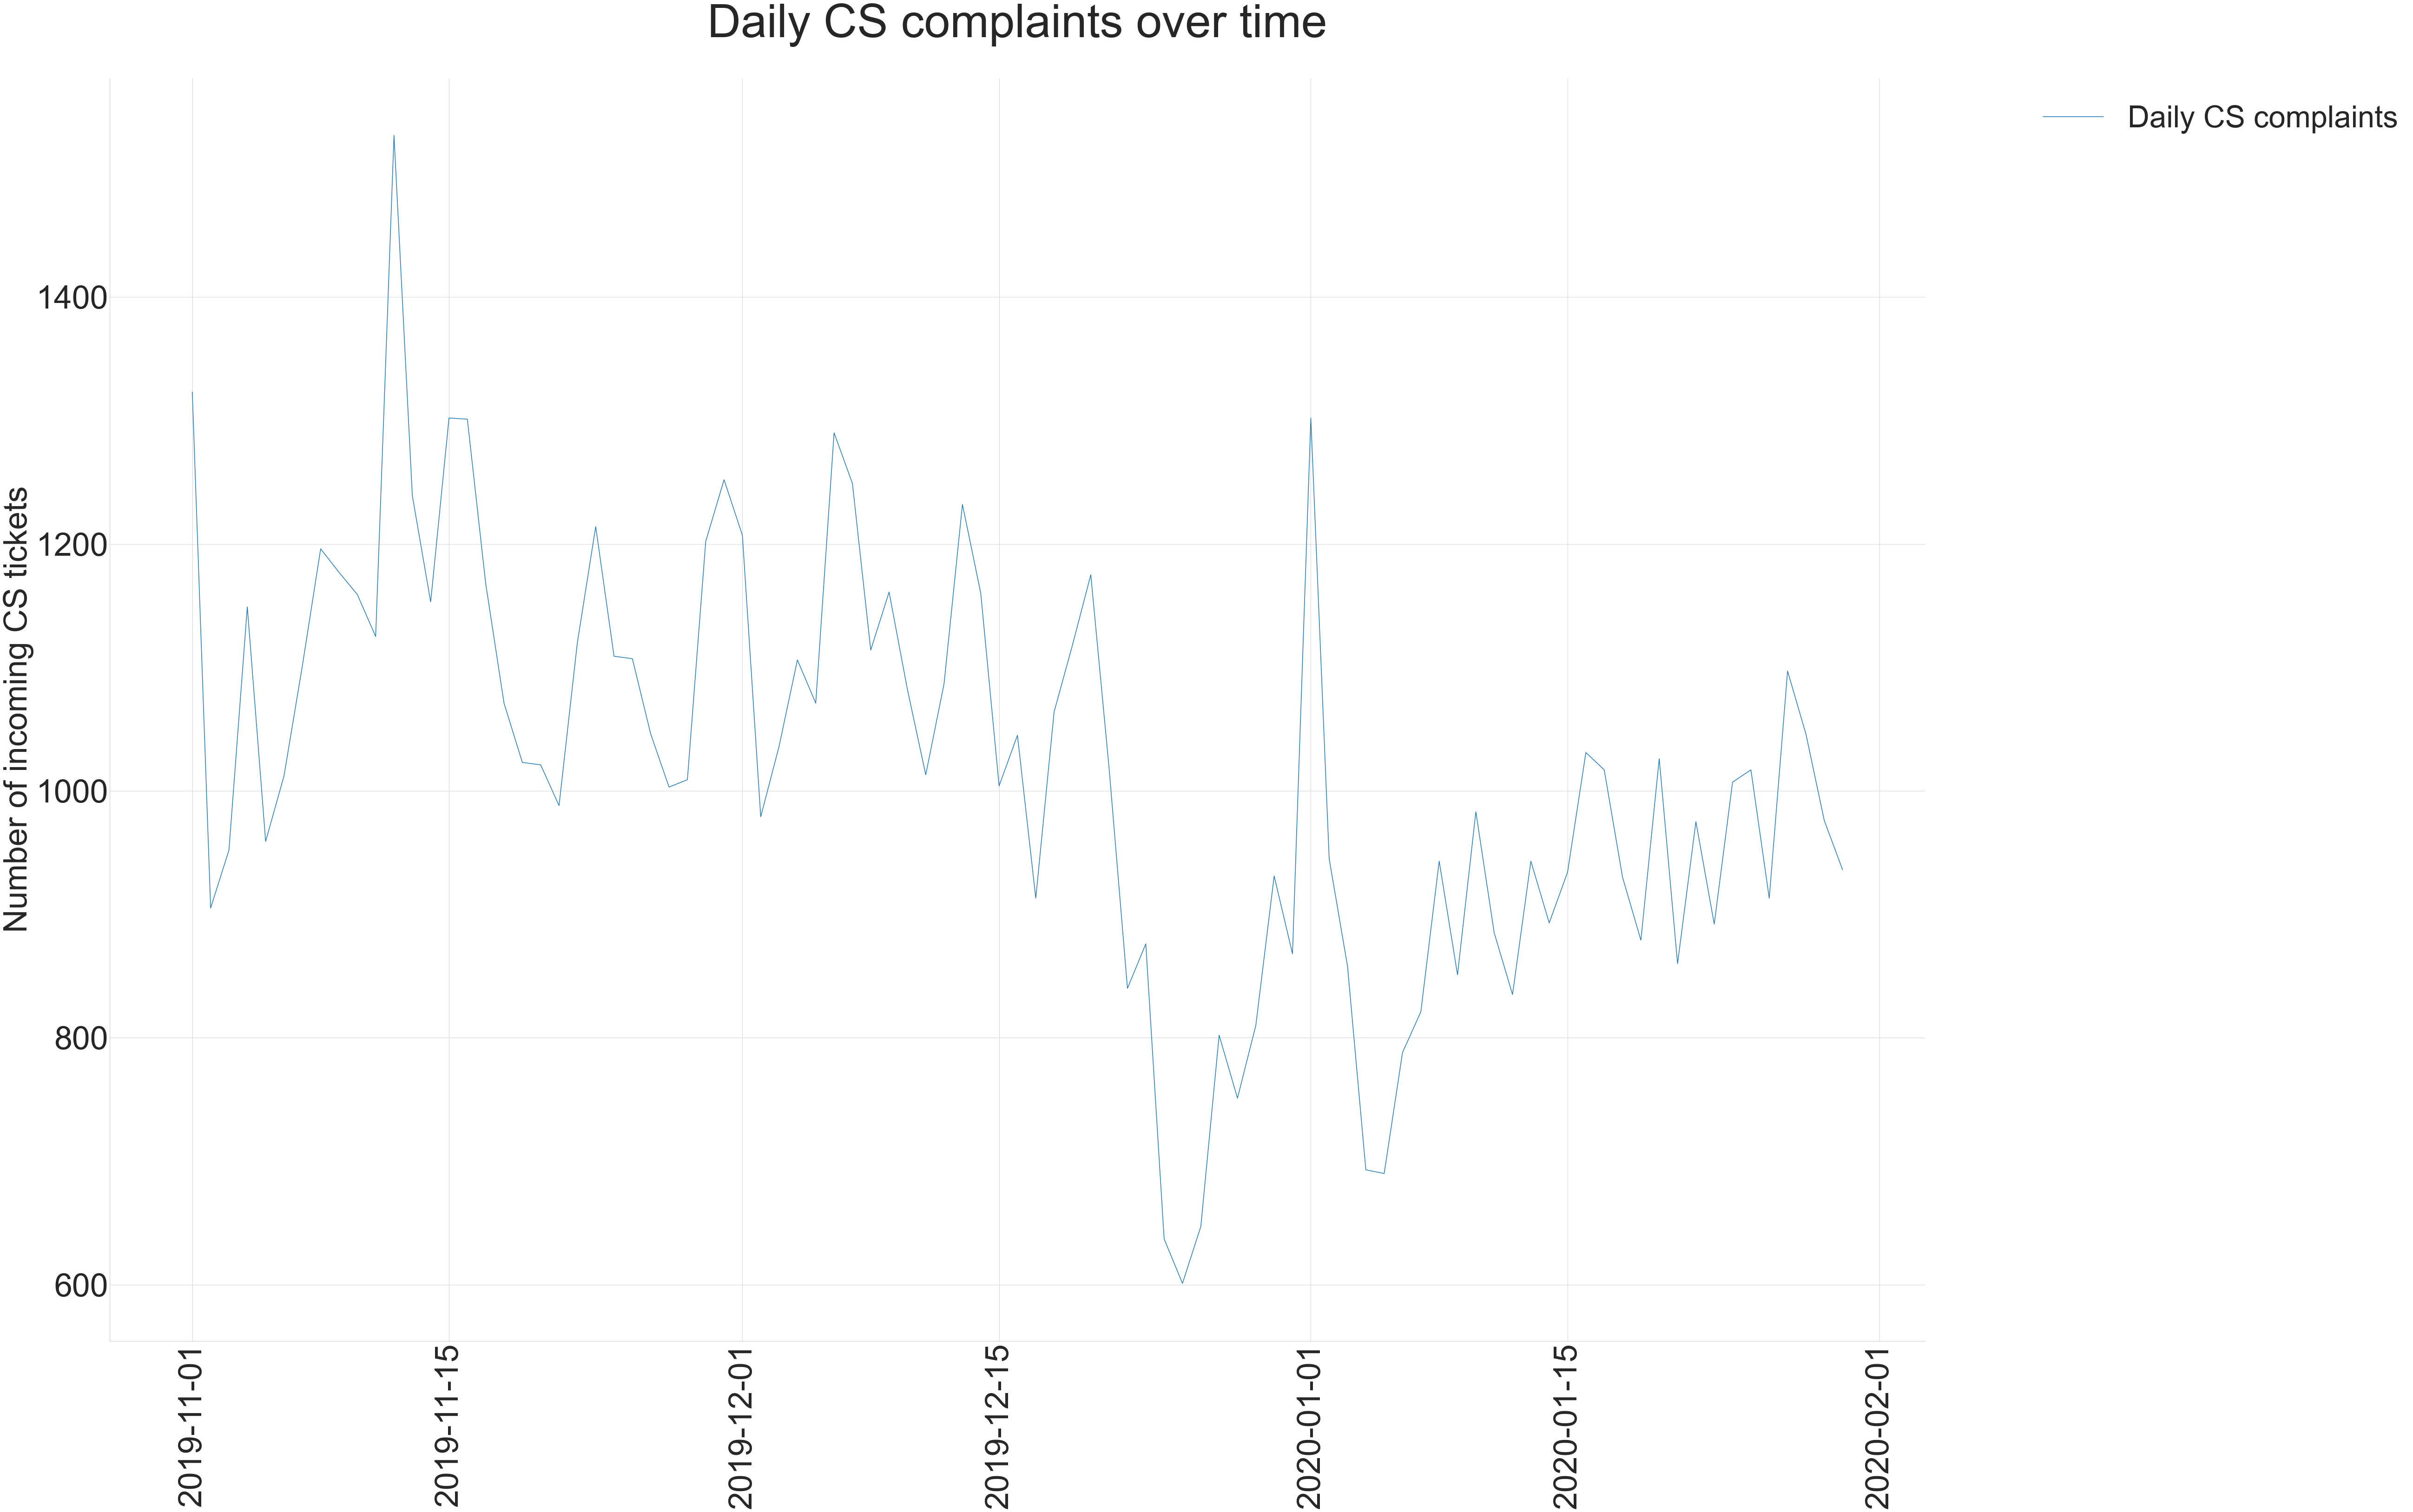

In [5]:
plt.rcParams["figure.figsize"] = (70,50)
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.plot( tickets_daily["y"], label="Daily CS complaints")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5,prop={'size':65})
plt.title('Daily CS complaints over time', fontsize=100, y=1.03)
plt.ylabel('Number of incoming CS tickets', fontsize=70)
label_size = 70
degrees = 90
plt.xticks(fontsize = label_size, rotation=degrees)
plt.yticks(fontsize = label_size)
plt.show()

Before testing for stationarity formally we can conduct a casual inspection of the graph. What we can see from the graph above is that the time series is clearly stationary, i.e. it fluctuates around what seems to be a constant average, or **baseline**. That also suggests that there is no linear trend in the data. This is good news for me because it means I should be able to fit any standard time-series forecasting model without any further transformations to the data.

Now, I will first formally break the series down to its three core components: trend, seasonality and noise.

In [6]:
def decompose_time_series(series):
    result = season.seasonal_decompose(series, model='additive')
    result.plot()
    plt.show()

An important caveat is that I can already choose to use the "additive" seasonality mode because we can be fairly certain that the seasonal variation is relatively constant over time.

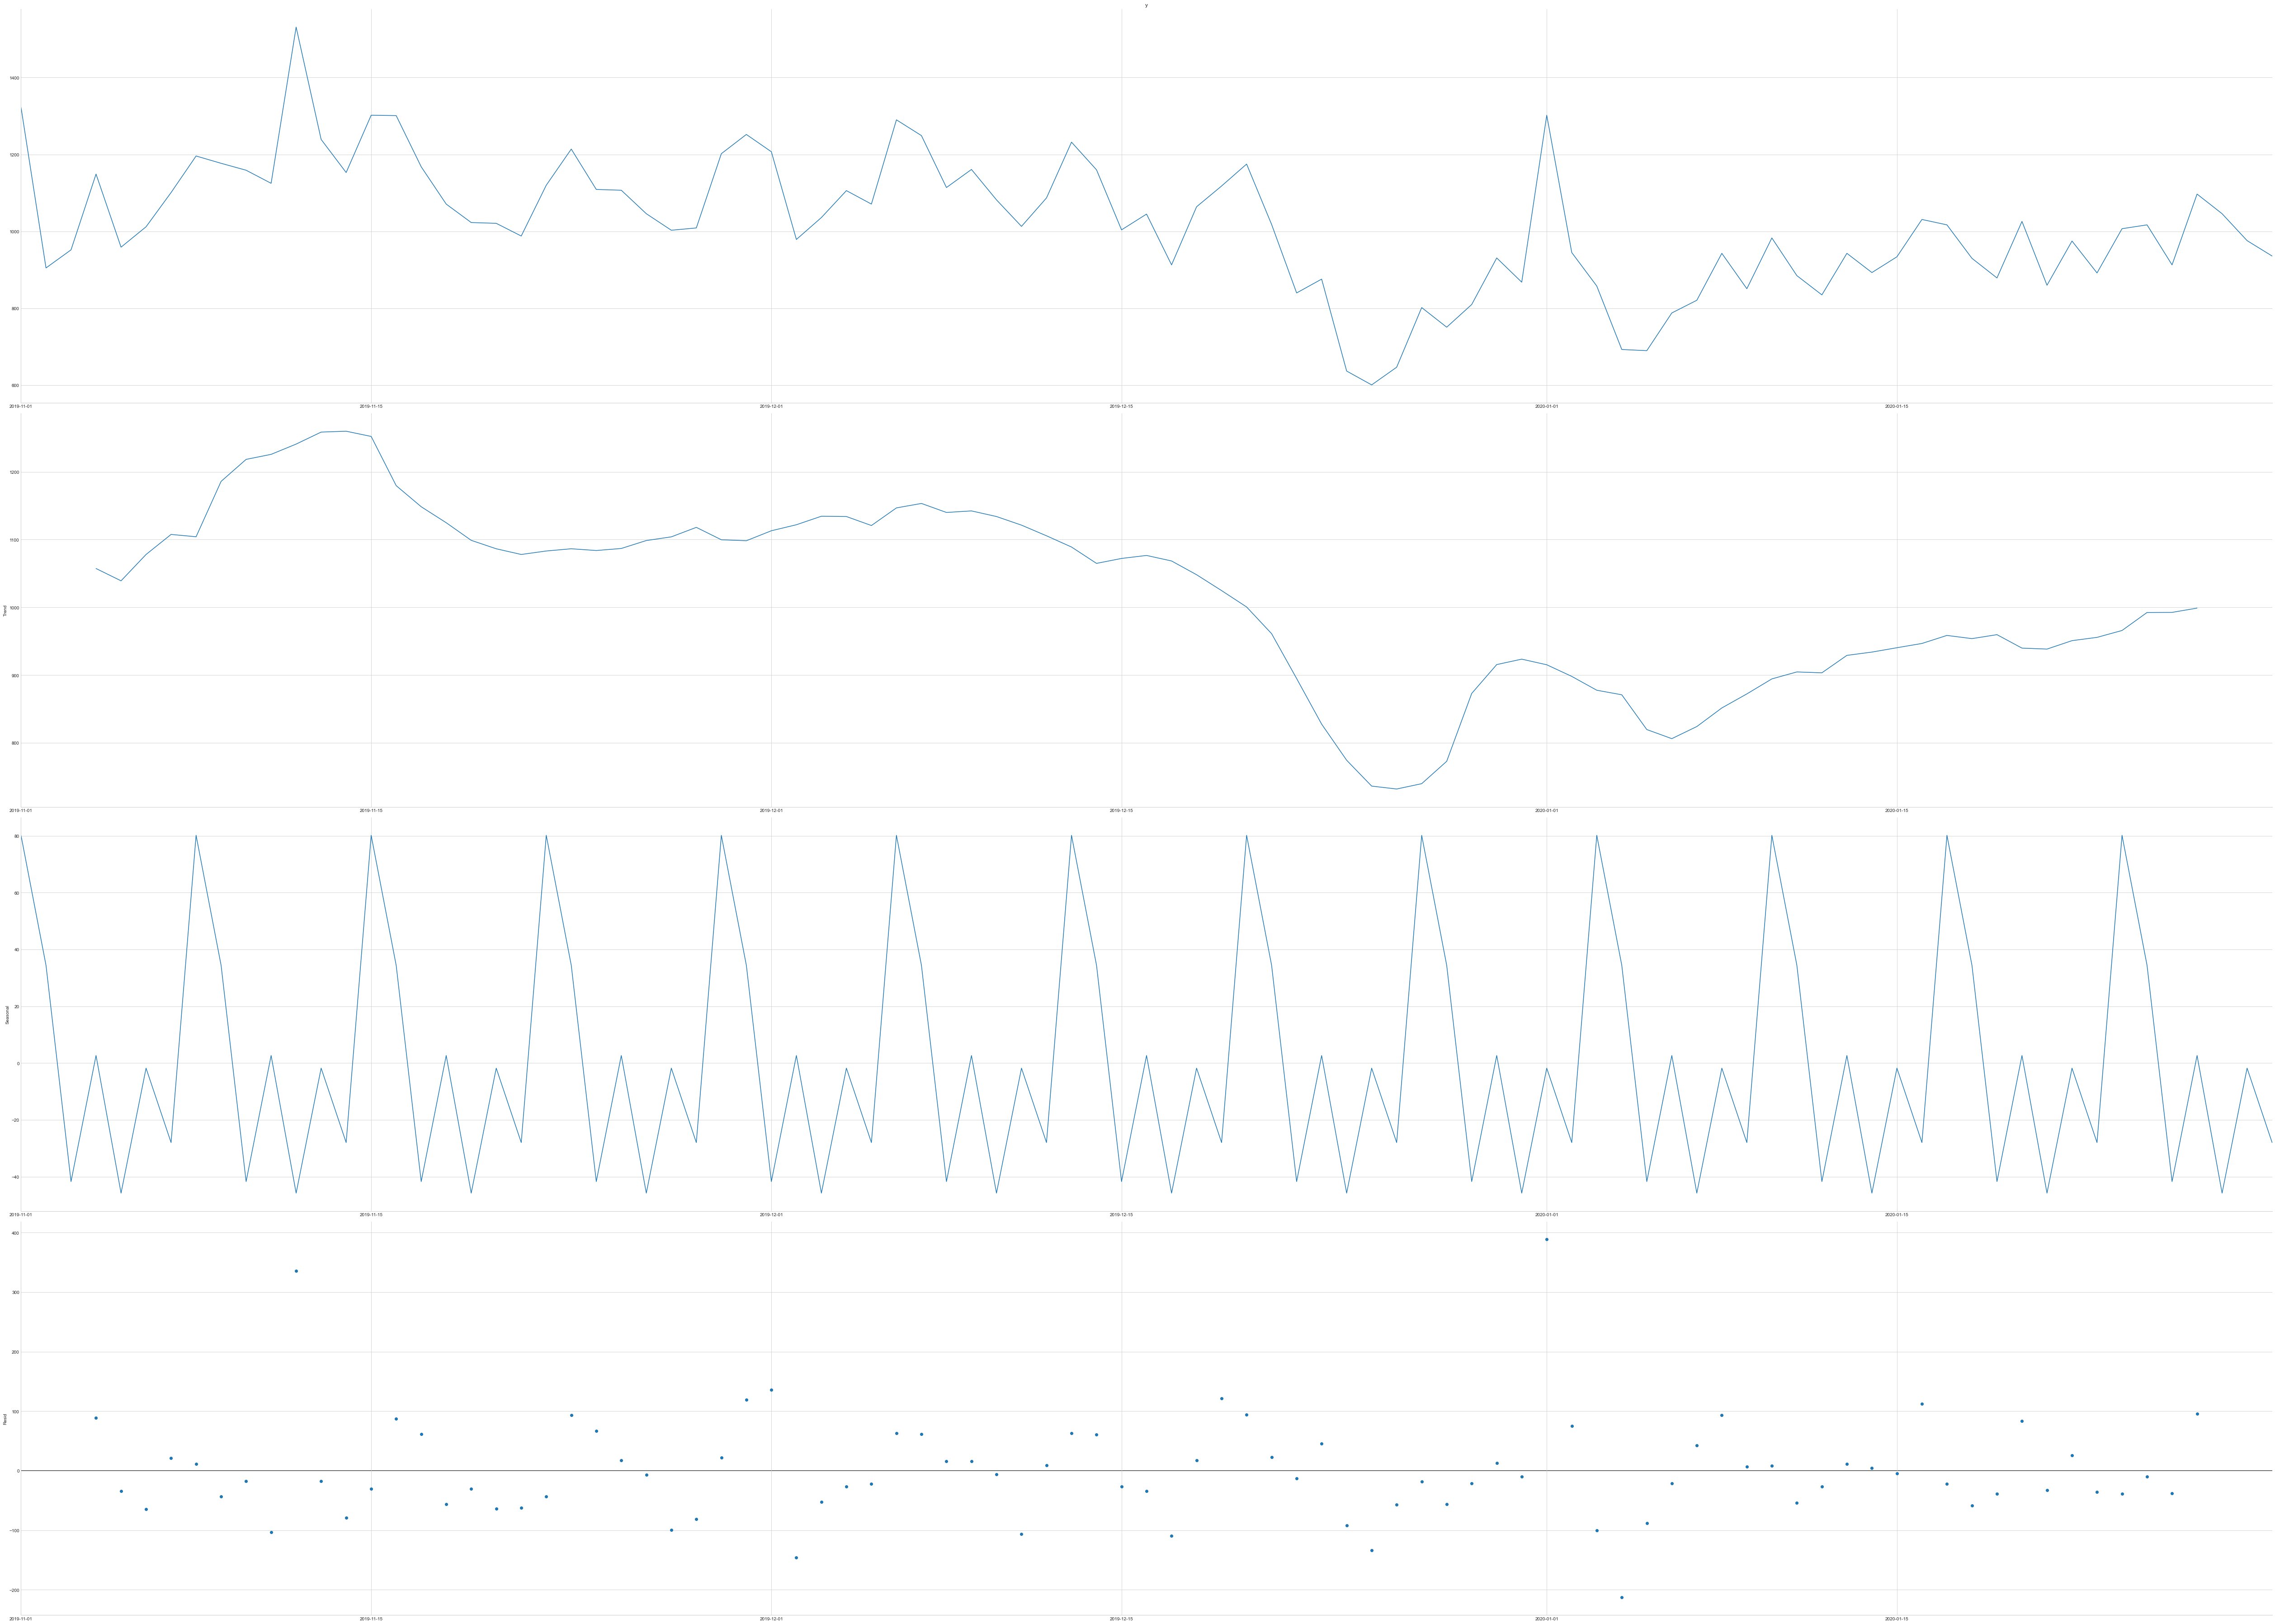

In [7]:
decompose_time_series(tickets_daily['y'])

#### Robust vs non-robust weighting.

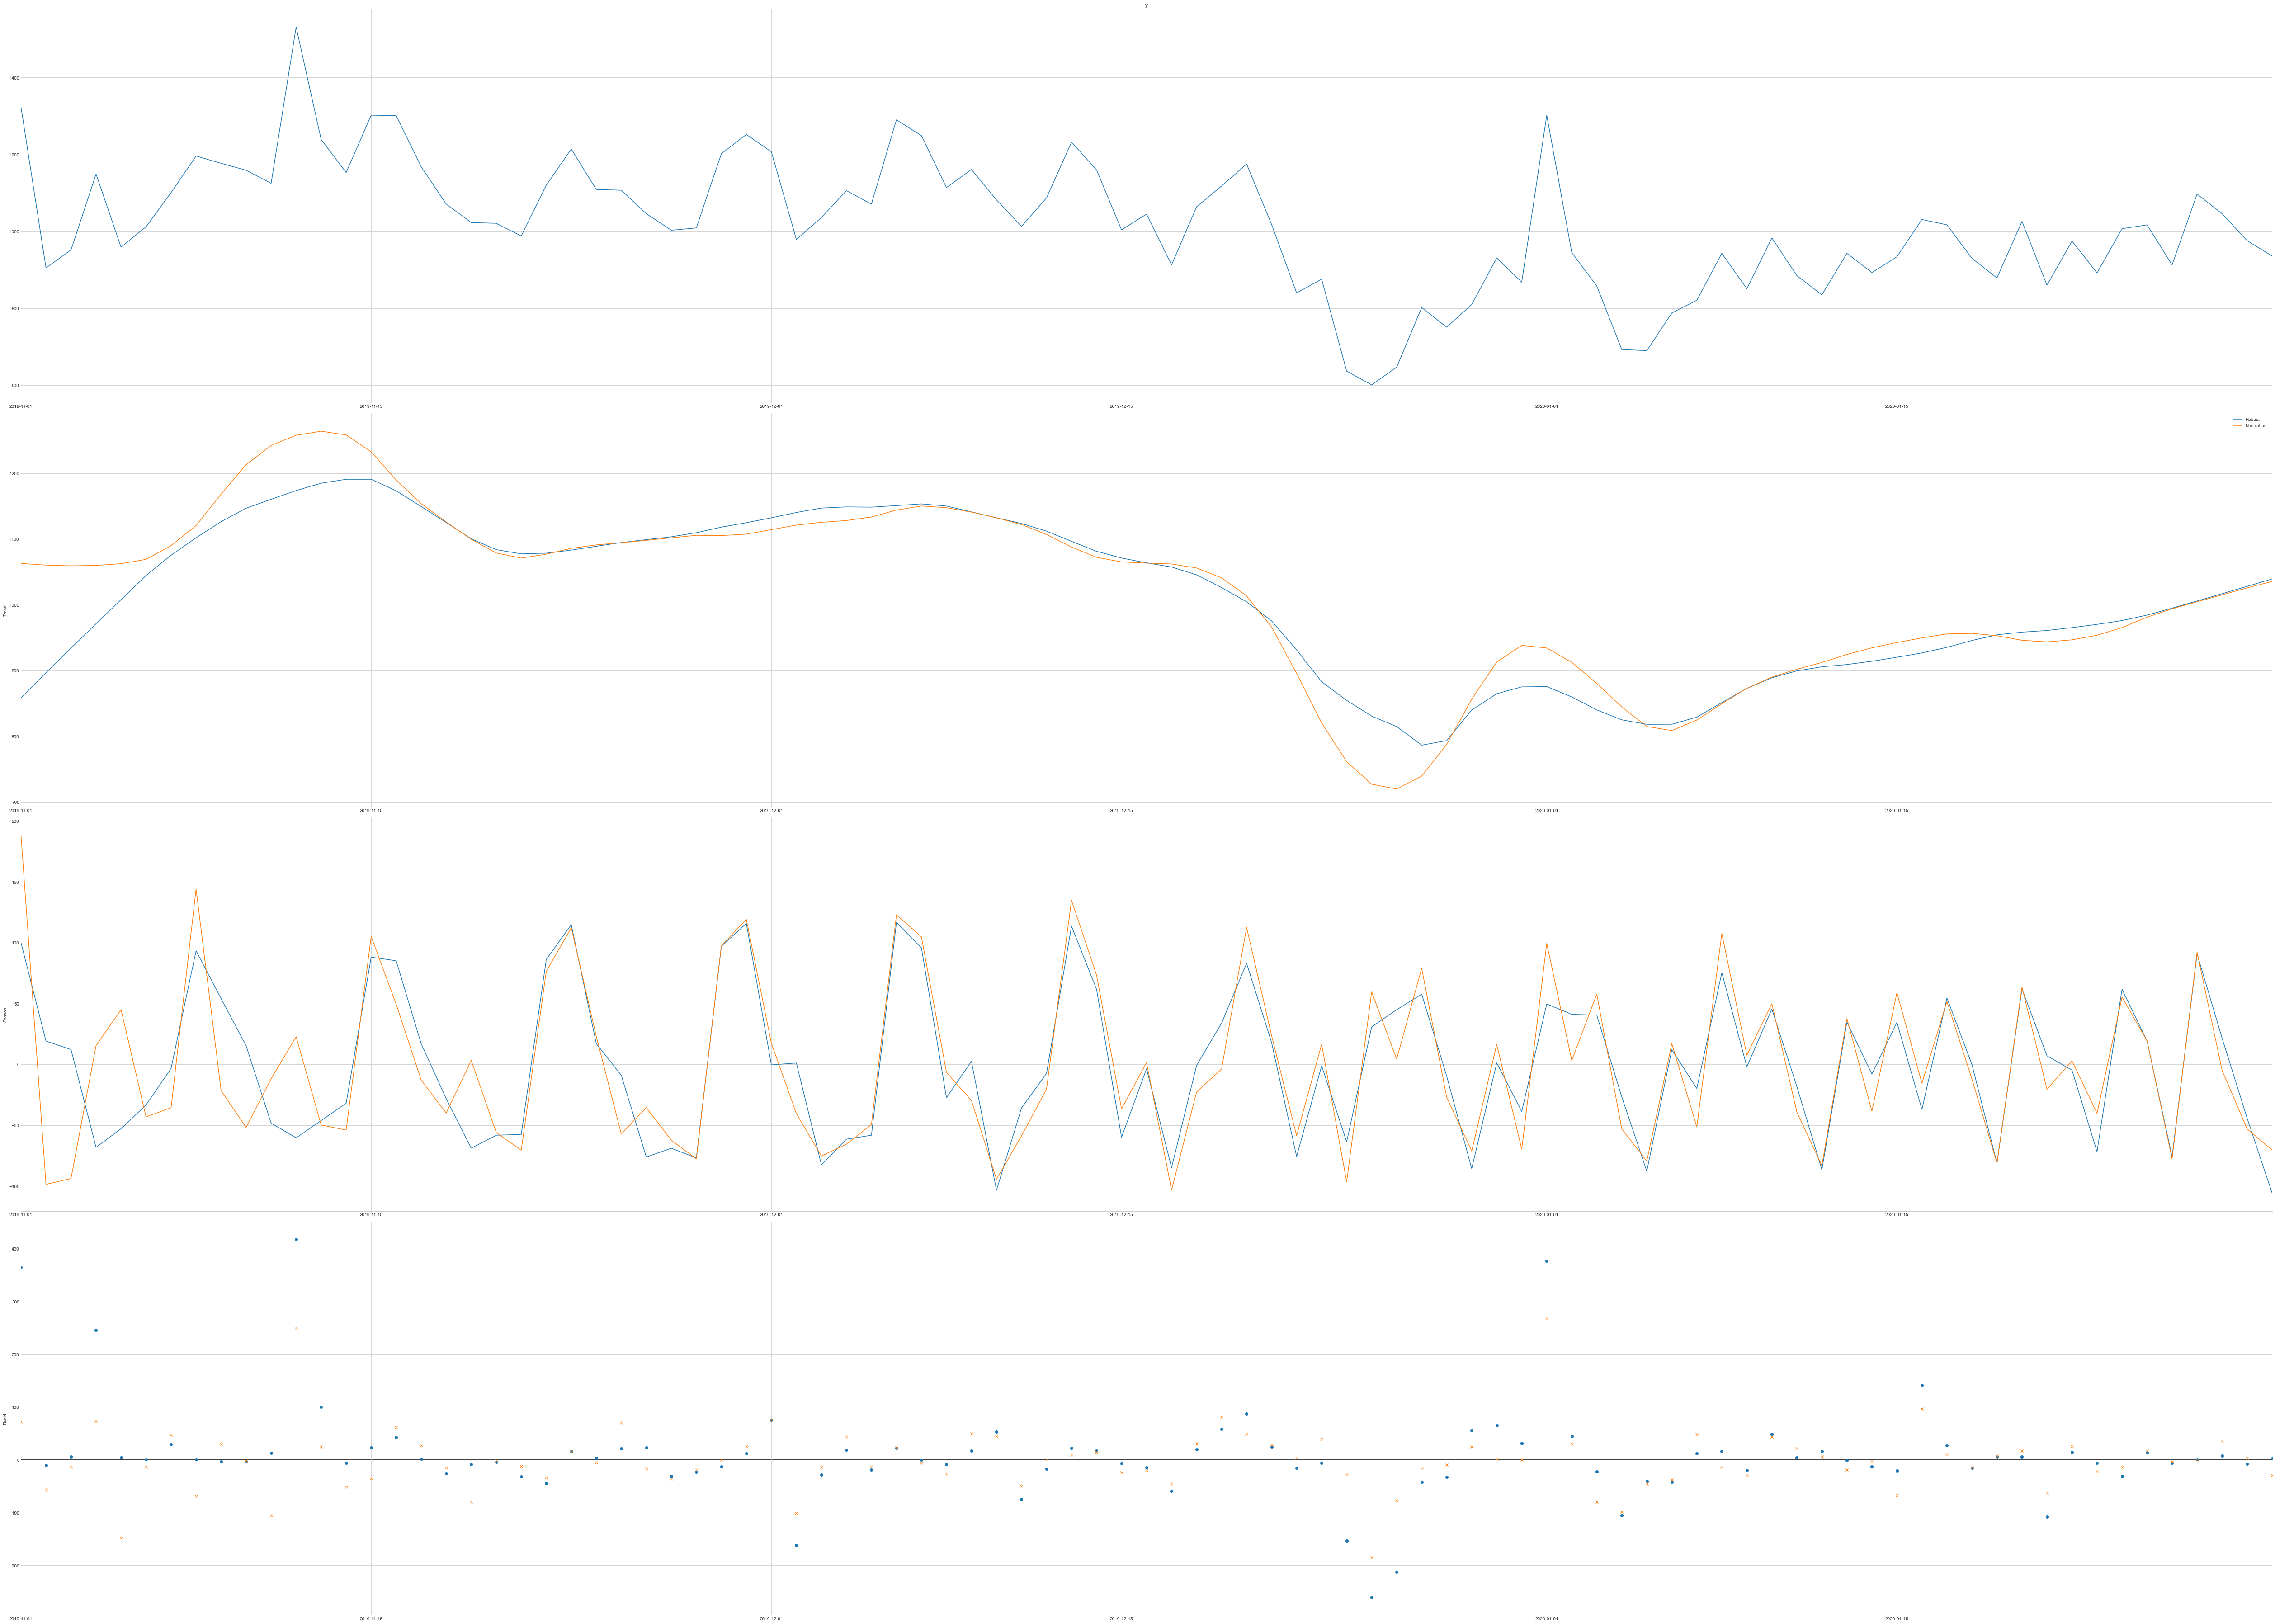

In [16]:
from statsmodels.tsa.seasonal import STL

def add_stl_plot(fig, res, legend):
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='x', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)

res_robust = STL(tickets_daily['y'], period=7, robust=True).fit()
fig = res_robust.plot()
res_non_robust = STL(tickets_daily['y'], period=7, robust=False).fit()
add_stl_plot(fig, res_non_robust, ['Robust', 'Non-robust'])

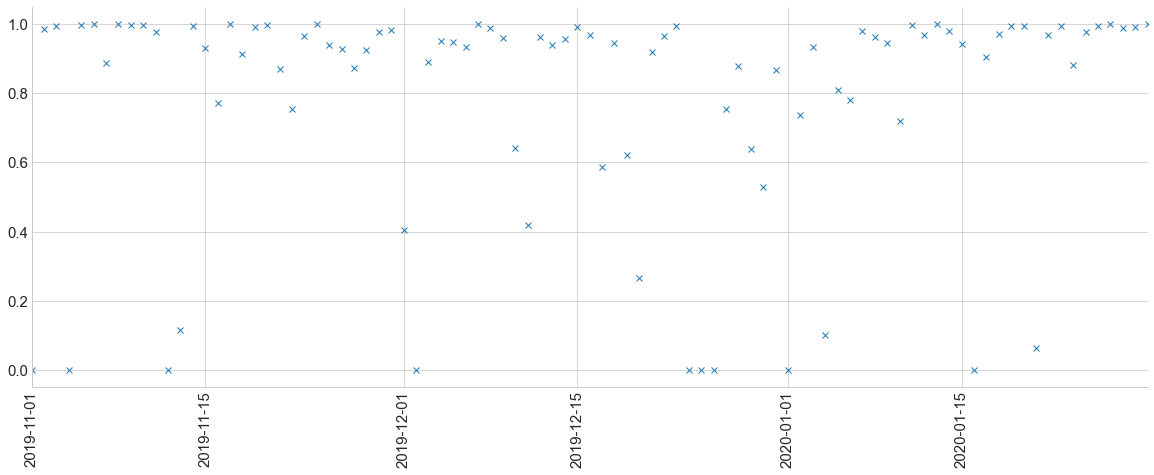

In [9]:
fig = plt.figure(figsize=(20,7))
lines = plt.plot(res_robust.weights, marker='x', linestyle='none')
ax = plt.gca()
xlim = ax.set_xlim(tickets_daily.index[0], tickets_daily.index[-1])
plt.xticks(fontsize = 15, rotation=degrees)
plt.yticks(fontsize = 15)
plt.show()

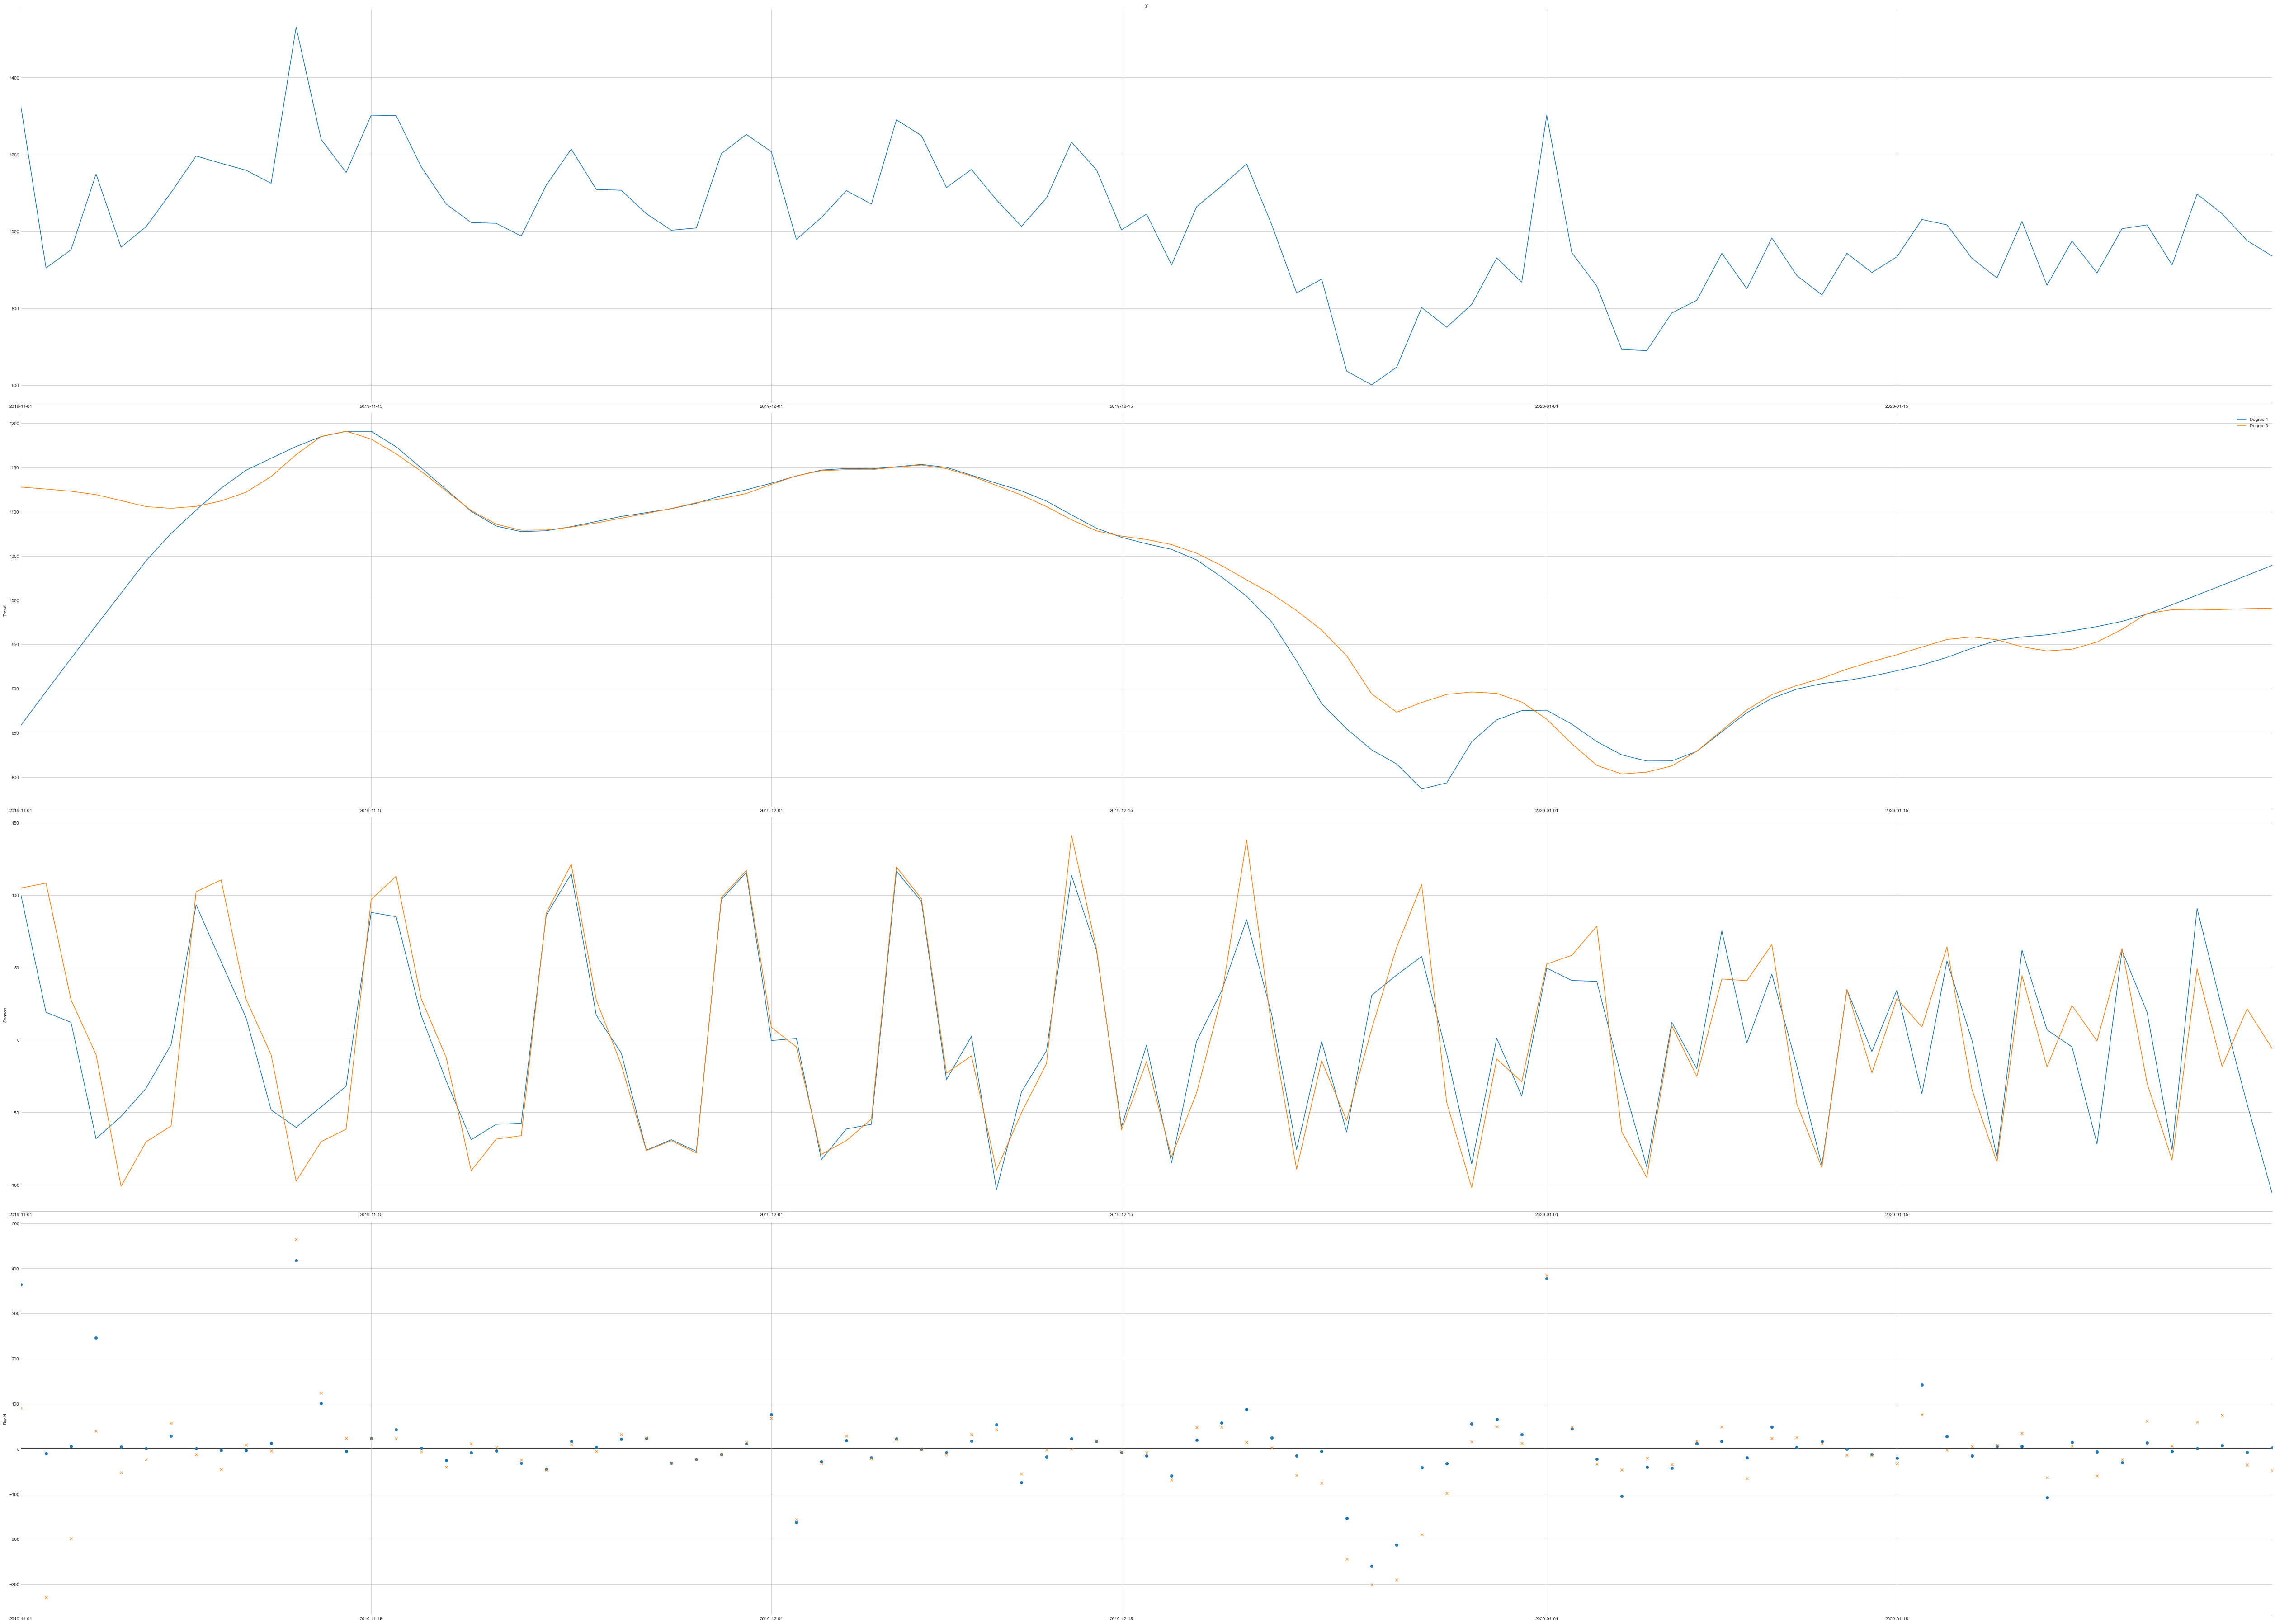

In [10]:
res_deg_0 = STL(tickets_daily['y'], period=7, seasonal_deg=0, trend_deg=0, low_pass_deg=0, robust=True).fit()
fig = res_robust.plot()
add_stl_plot(fig, res_deg_0, ['Degree 1','Degree 0'])

#### Forecasting with STL:

Let's note that the predicted values reflect the inherent seasonality but don't really capture the extreme peaks and the dips present in the original dataset.

#### Validating the STL forecast:

To have a rough idea of how accurate our forecast is, we need to split the initial dataset into a training and a testing set. The model will be fit on the training data only, then out-of-sample forecasts will be once again generated and compared against the actual values for the same time period contained in the testing set.

In [13]:
import statsmodels.tsa.api
from statsmodels.tsa.api import STLForecast

ImportError: cannot import name 'STLForecast' from 'statsmodels.tsa.api' (/Users/aida.aman/Desktop/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/api.py)

In [ ]:
master_array=np.array(tickets_daily[['y']].dropna())
train = master_array[:int(0.8*(len(master_array)))]
test = master_array[int(0.8*(len(master_array))):]

In [ ]:
train = train.reshape(72,1)
c = train.flatten()
new_series = pd.Series(c)
dataset = new_series.to_frame()
dataset = dataset.rename(columns={0:'y'})
dataset['ds'] = pd.date_range(start='2019-11-01', periods=72, freq='D')
dataset = dataset.set_index(dataset['ds'])

In [ ]:
test = test.reshape(19,1)
c = test.flatten()
new_series = pd.Series(c)
test_df = new_series.to_frame()
test_df = test_df.rename(columns={0:'y'})

In [ ]:
dataset.index.freq = dataset.index.inferred_freq
stlf_res = STLForecast(dataset['y'], ARIMA, model_kwargs=dict(order=(1,1,0), trend="c")).fit()
forecast = stlf_res.forecast(19)
test_df['ds'] = pd.date_range(start='2020-01-12', periods=19, freq='D')
test_df = test_df.set_index(test_df['ds'])

In [ ]:
test_df['y'].plot()
forecast.plot()
plt.show()

I will create a custom function that computes Mean Absolute Prediction Error.

In [ ]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [ ]:
mape = mape(test_df['y'], forecast)
print(mape)

#### Comparing FbProphet with STL based on the RMSE metric:

In [ ]:
import sklearn
from sklearn import metrics
mse = sklearn.metrics.mean_squared_error(test_df['y'], forecast)

In [ ]:
print(mse)

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [ ]:
Prophet_baseline = Prophet(weekly_seasonality = True)
Prophet_baseline.fit(dataset)

In [ ]:
future = Prophet_baseline.make_future_dataframe(periods = 19, freq = 'D')
forecast_Pr = Prophet_baseline.predict(future)
indexNames = forecast_Pr[ forecast_Pr['ds'] < '2020-01-12'].index
forecast_Pr.drop(indexNames , inplace=True)

In [ ]:
mse_Pr = sklearn.metrics.mean_squared_error(test_df['y'], forecast_Pr['yhat'])

In [ ]:
print(mse_Pr)

In [ ]:
mse < mse_Pr

This means that the much simplet STL model vastly outperforms forecasts generated by FbProphet.

In [ ]:
conda activate py37

In [ ]:
import IPython
from IPython.display import HTML

In [ ]:
from IPython.display import Image, YouTubeVideo
from IPython.display import display

I can also create an interactive report which is what I will proceed to next. Sharing your insights with the rest of the team in a user-friendly format that is also not prone to front-end manipulations on behalf of the consumers of the data is quite important and, unfortunately not very straightforward if one is using Jupyter. 

Before proceeding further, there is one more approach I am eager to try out, Bayesian Structural Modelling using Tensorflow Probability.

In [ ]:
import matplotlib.dates as mdates
from matplotlib import pyplot as plt

In [ ]:
from pandas.plotting import register_matplotlib_converters

In [ ]:
import seaborn as sns
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

As a modeller I might use the recomposition in order to understand how the model can be potentially improved. For instance, I notice that the residual spikes and the dips that still remain after the series has been deseasoned and de-trended tend to coincide with special dates that can be explicitly accounted for.

The inferred parameters from the decomposition imply the non-zero seasonality degree.

In [ ]:
import os
print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
print("PATH:", os.environ.get('PATH'))

In [ ]:
conda install -c anaconda numpy

It seems I still have to investigate the dip in engagement on November 12.

Potential causes of a dip in engagement include the following:
- **Product-related issues.** There may have been a bug in the product that deterred users from using the product. Similarly, Yammer may have released a product update around the beginning of August, which a significant number of users did not like.

- **Time of the year.** August may simply be a month when a lot of users go on vacation. This may be the case if a significant portion of users are parents, as they tend to go on vacations before September when school starts.

- **Competitors.** It’s possible that a competitor launched a competing product at the beginning of August, or a competitor released significant updates to an existing product that caused users to churn.

- **Data not being tracked properly.** It’s possible that the data pipelines are not working, and thus, the data is not being tracked properly. This is a problem caused internally and would require the help of data engineers to fix.

- **Marketing event.** When large promotions are launched, it’s normal that a company will attract lower quality customers because of the discounts provided. Therefore, it’s a possibility that the dip in August is the aftereffect of a large marketing event in July.

In [ ]:
import numpy as np

In [ ]:
import os
print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
print("PATH:", os.environ.get('PATH'))

In [ ]:
os.chdir("/Users/aida.aman/Desktop/AERC")

In [ ]:
constr_raw = pd.read_csv("baiterek_bcleaning.csv")

In [ ]:
constr_raw['quarter']=constr_raw['quarter'].replace('Q1', 1)
constr_raw['quarter']=constr_raw['quarter'].replace('Q2', 2)
constr_raw['quarter']=constr_raw['quarter'].replace('Q3', 3)
constr_raw['quarter']=constr_raw['quarter'].replace('Q4', 4)

In [ ]:
constr_raw

In [ ]:
FRT_daily = tickets['first_response_time'].resample('D').mean()
FRT_daily = FRT_daily.to_frame()

In [ ]:
FRT_daily

In [ ]:
plt.plot( FRT_daily["first_response_time"])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5,prop={'size':65})
plt.title('First Response Time for the last 12 weeks', fontsize=40, y=1.03)
plt.ylabel('Time lapsed until first response', fontsize=30)
label_size = 30
degrees = 90
plt.xticks(fontsize = label_size, rotation=degrees)
plt.yticks(fontsize = label_size)
plt.show()

The workforce schedule has to be determined in shifts (morning - 9:00 am - 6:00 pm and evening 12:00 pm - 9 pm)

### Model performance: